In [ ]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Deciding the device type.
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [ ]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.c0 = nn.ConvTranspose2d(100, 512, 4, 1, 0, bias = False)
    self.c1 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias = False)
    self.c2 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias = False)
    self.c3 = nn.ConvTranspose2d(128, 64, 4, 2, 1, bias = False)
    self.c4 = nn.ConvTranspose2d(64, 32, 4, 2, 1, bias = False)
    self.c5 = nn.ConvTranspose2d(32, 3, 4, 2, 1, bias = False)

    # batch normalization
    self.bn0 = nn.BatchNorm2d(512)
    self.bn1 = nn.BatchNorm2d(256)
    self.bn2 = nn.BatchNorm2d(128)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(32)

  # Forward propagation
  def forward(self, x):
    x = F.relu(self.bn0(self.c0(x)))
    x = F.relu(self.bn1(self.c1(x)))
    x = F.relu(self.bn2(self.c2(x)))
    x = F.relu(self.bn3(self.c3(x)))
    x = F.relu(self.bn4(self.c4(x)))

    return torch.tanh(self.c5(x))

In [ ]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.c1 = nn.Conv2d(3, 32, 4, 2, 1, bias = False)
    self.c2 = nn.Conv2d(32, 64, 4, 2, 1, bias = False)
    self.c3 = nn.Conv2d(64, 128, 4, 2, 1, bias = False)
    self.c4 = nn.Conv2d(128, 256, 4, 2, 1, bias = False)
    self.c5 = nn.Conv2d(256, 512, 4, 2, 1, bias = False)
    self.c6 = nn.Conv2d(512, 1, 4, 1, 0, bias = False)

    # batch Normalization
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(128)
    self.bn4 = nn.BatchNorm2d(256)
    self.bn5 = nn.BatchNorm2d(512)

  # forward propagation
  def forward(self, x):
    x = F.leaky_relu(self.c1(x), 0.2, inplace = True)

    x = F.leaky_relu(self.c2(x), 0.2, inplace = True)
    x = self.bn2(x)

    x = F.leaky_relu(self.c3(x), 0.2, inplace = True)
    x = self.bn3(x)

    x = F.leaky_relu(self.c4(x), 0.2, inplace = True)
    x = self.bn4(x)

    x = F.leaky_relu(self.c5(x), 0.2, inplace = True)
    x = self.bn5(x)

    return torch.sigmoid(self.c6(x)).view(-1,1)

In [ ]:
lossFunc = nn.BCELoss() # Binary cross entropy loss

# initiating the models.
dNet = discriminatorNet().to(device)
gNet = generatorNet().to(device)

# optimizers defined.
dOpt = optim.Adam(dNet.parameters(), lr = 0.0002, betas = (0.5, 0.999))
gOpt = optim.Adam(gNet.parameters(), lr = 0.0002, betas = (0.5, 0.999))

discriminatorNet(
  (c1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c5): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (c6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
generatorNet(
  (c0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (c1): ConvTranspose2

In [ ]:
# Loading the models
gNet = generatorNet()
dNet = discriminatorNet()

# loading the trained models from files.
gNet.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/generator128.pth'))
dNet.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/discriminator128.pth'))

gNet.to(device)
dNet.to(device)

# Loading the optimizers
gOpt.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/g_optimizer128.pth'))
dOpt.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/SavedModel/d_optimizer128.pth'))

<ipython-input-34-ba4c932c43b4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gNet.load_state_dict(torch.load('/content/drive/MyDrive/Brock University/8th Semester/COSC 4

In [ ]:
dataroot = "/content/drive/MyDrive/Brock University/8th Semester/COSC 4P80/4P80 Project/data/forgeryNet2KSample"

In [ ]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(128),
                               transforms.CenterCrop(128),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])) # image transformation and converting to tensors.

In [ ]:
from torch.utils.data import Subset
dataset = Subset(dataset, range(1400, len(dataset))) # taking 600 samples from the dataset.

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2) # dataloader loads the dataset in number of batches

In [ ]:
len(dataloader)

38

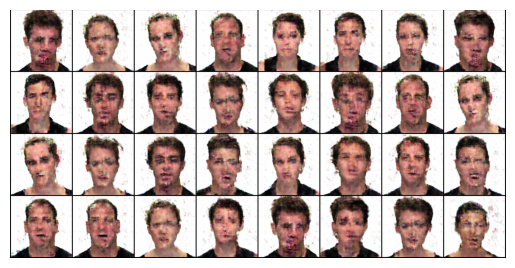

In [ ]:
gNet.eval()
noise = torch.randn(32, 100, 1, 1, device=device)  # Batch size = 1
with torch.no_grad():
    fake_image = gNet(noise).detach().cpu()

import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Converting tensors to image format
fake_image = fake_image.squeeze(0)  # Remove batch dimension
fake_image = vutils.make_grid(fake_image, normalize=True)

# Displaying the images
plt.imshow(fake_image.permute(1, 2, 0))  # Rearranges dimensions
plt.axis('off')
plt.show()

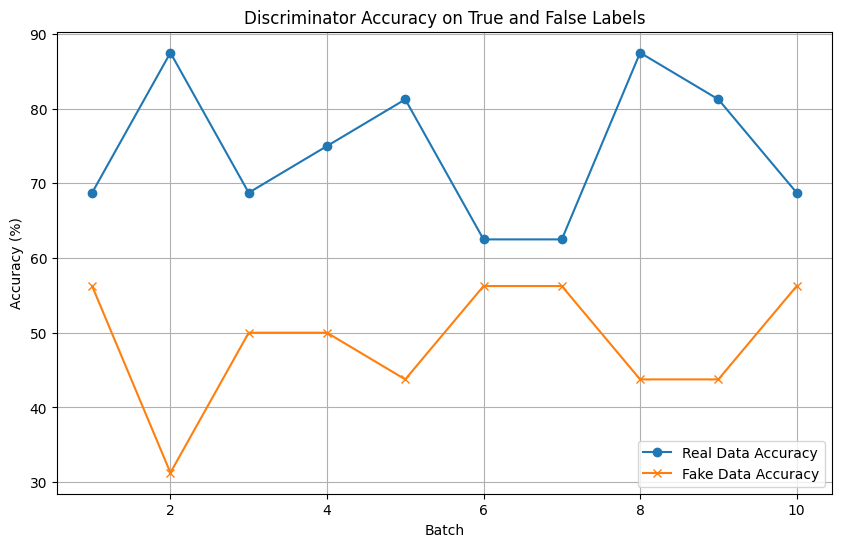

In [ ]:
import matplotlib.pyplot as plt

def plot_discriminator_accuracy(dNet, dataloader, gNet, device, num_batches=10):
    """
      This section evaluates the discriminator's accuracy for real and fake images
      and plots the accuracy graph.
    """
    dNet.eval()
    gNet.eval()

    real_accuracies = []
    fake_accuracies = []

    with torch.no_grad():
        for batch_idx, data in enumerate(dataloader):
            if batch_idx >= num_batches:
                break

            # Real images
            real_images = data[0].to(device)
            batch_size = real_images.size(0)
            labels_real = torch.ones(batch_size, 1, device=device)

            outputs_real = dNet(real_images)
            predictions_real = (outputs_real > 0.5).float()
            correct_real = (predictions_real == labels_real).sum().item()
            real_accuracy = correct_real / batch_size * 100
            real_accuracies.append(real_accuracy)

            # Fake images
            noise = torch.randn(batch_size, 100, 1, 1, device=device)
            fake_images = gNet(noise)
            labels_fake = torch.zeros(batch_size, 1, device=device)

            outputs_fake = dNet(fake_images)
            predictions_fake = (outputs_fake > 0.5).float()
            correct_fake = (predictions_fake == labels_fake).sum().item()
            fake_accuracy = correct_fake / batch_size * 100
            fake_accuracies.append(fake_accuracy)

    # Plotting the real and fake accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(real_accuracies) + 1), real_accuracies, label='Real Data Accuracy', marker='o')
    plt.plot(range(1, len(fake_accuracies) + 1), fake_accuracies, label='Fake Data Accuracy', marker='x')
    plt.title("Discriminator Accuracy on True and False Labels")
    plt.xlabel("Batch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()

plot_discriminator_accuracy(dNet, dataloader, gNet, device)